In [ ]:
import pandas as pd
import numpy as np
from numpy import where, mean
import nltk, string
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, RepeatedStratifiedKFold

from matplotlib import pyplot
from collections import Counter

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE


# Wczytanie danych
Pierwsza kolumna to "sample_id", a ostatnia kolumna to CLASS oznaczająca klasę. Reszta to wartości liczbowe separowane znakiem ";"

In [2]:
RNG = np.random.RandomState(42)
CLASS = "CLASS"
SAMPLE_ID = "sample_id"

alleu_data = pd.read_csv("csv/ALL_GSE13425_FINAL.csv", sep=';')
btu_data = pd.read_csv("csv/BTu_GSE4290_FINAL.csv", sep=';')
hec_data = pd.read_csv("csv/HeC_GSE14323_FINAL.csv", sep=';')
hff_data = pd.read_csv("csv/HFF_GSE5406_FINAL.csv", sep=';')
sps_data = pd.read_csv("csv/SPs_GSE13355_FINAL.csv", sep=';')
ssh_data = pd.read_csv("csv/SSh_GSE13904_FINAL.csv", sep=';')


In [3]:
def clean_data(df):
    s = df.drop(columns=[CLASS, SAMPLE_ID]).select_dtypes(include='object').columns
    df[s] = df[s].apply(lambda x: x.astype(float))
    return df

datasets = {
    "ALL": clean_data(alleu_data),
    "BTU": clean_data(btu_data),
    "HEC": clean_data(hec_data),
    "HFF": clean_data(hff_data),
    "SPS": clean_data(sps_data),
    "SSH": clean_data(ssh_data)
}

In [ ]:
def show_data(df, name):
    print(f"{name} Data:")
    print(df.describe())
    print(f"Liczba właściwości: {df.shape[1] - 1}")
    print(f"Liczba klas: {df[CLASS].nunique()}")
    class_counts = df[CLASS].value_counts().sort_index()
    for label, count in class_counts.items():
        print(f"\tKlasa {label} ({label}): {count}")
    
    print(f"Brakujące wartości: {df.isnull().sum().sum()}\n")

show_data(datasets["ALL"], "LEUKEMIA")

LEUKEMIA Data:
        1007_s_at     1053_at      117_at      121_at   1255_g_at     1294_at  \
count  190.000000  190.000000  190.000000  190.000000  190.000000  190.000000   
mean     2.438896    1.638419    1.318517    3.200177    0.645687    2.721838   
std      0.579214    0.634879    0.885723    0.208595    0.592723    0.392265   
min      0.337507   -0.628989   -0.442846    2.568316   -0.712669    1.741091   
25%      2.125028    1.364003    0.833053    3.066082    0.181335    2.443909   
50%      2.526099    1.748100    1.327829    3.218801    0.821112    2.714547   
75%      2.799807    2.056160    1.684112    3.331281    1.122179    2.987919   
max      3.515396    2.767048    5.585059    3.713041    1.678102    4.020557   

          1316_at     1320_at   1405_i_at     1431_at  ...  \
count  190.000000  190.000000  190.000000  190.000000  ...   
mean     1.555640    0.528180    0.549729    0.973860  ...   
std      0.334517    0.687860    0.814795    0.573423  ...   
min    

Wykres danych czystych

Tworzenie wykresu ALL...
Counter({'TEL-AML1': 44, 'hyperdiploid': 44, 'pre-BALL': 44, 'T-ALL': 36, 'E2A': 13, 'BCR-ABL': 5, 'MLL': 4})
Tworzenie wykresu BTU...
Counter({'glioblastoma': 81, 'oligodendroglioma': 50, 'astrocytoma': 26, 'non-tumor': 23})
Tworzenie wykresu HEC...
Counter({'HCC': 47, 'cirrhosis': 41, 'Normal': 19, 'cirrhosisHCC': 17})
Tworzenie wykresu HFF...
Counter({'ischemic_cardiomyopathy': 108, 'idiopathic_cardiomyopathy': 86, 'normal': 16})
Tworzenie wykresu SPS...
Counter({'normal': 64, 'uninvolved': 58, 'involved': 58})
Tworzenie wykresu SSH...
Counter({'Septic_Shock': 106, 'Sepsis': 52, 'SIRS': 27, 'SIRS_resolved': 24, 'Controls': 18})


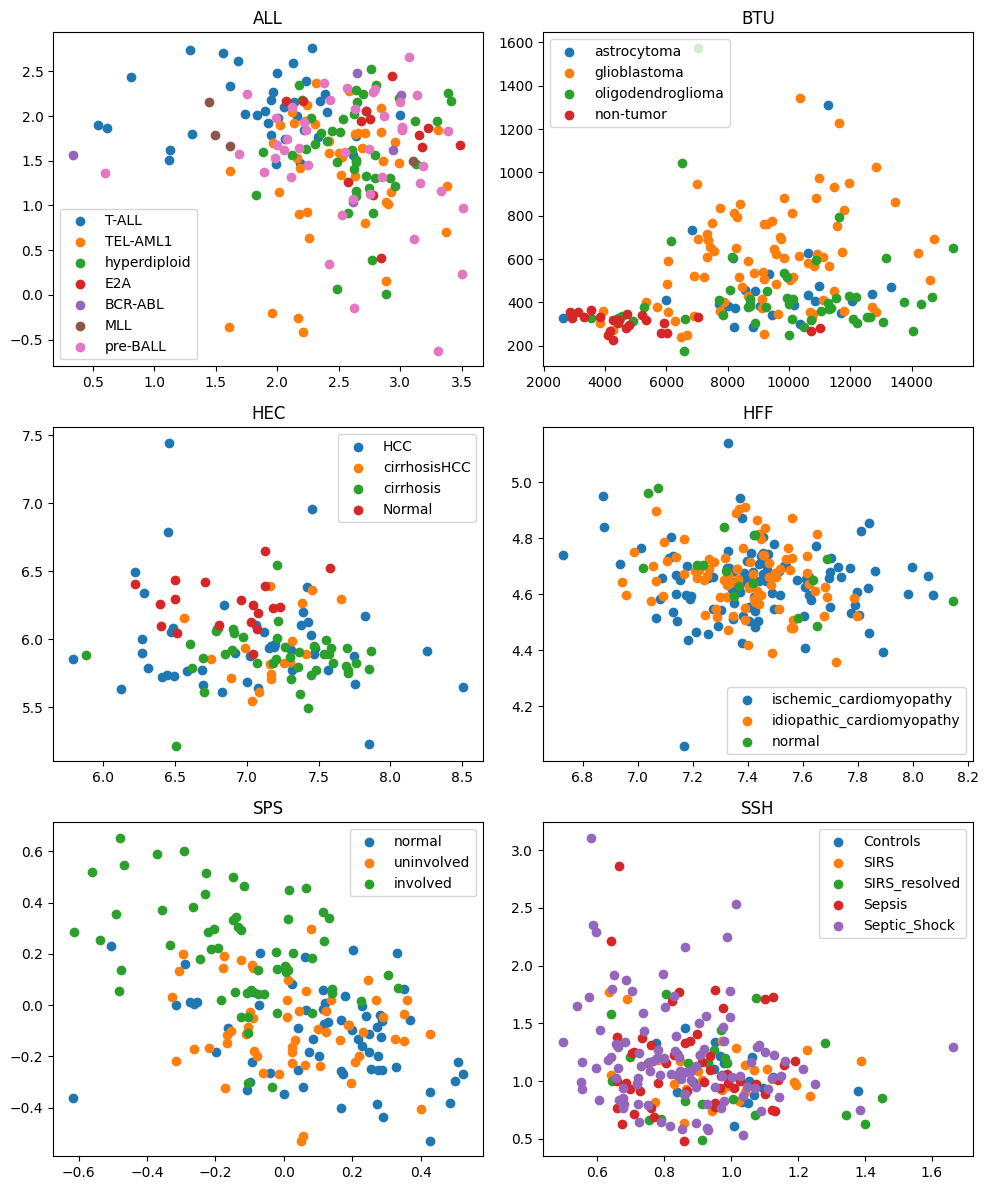

In [36]:
# Generate and plot a synthetic imbalanced classification dataset
def plot_datasets(datasets):
    n_plots = len(datasets)
    cols = 2
    rows = (n_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    axes = axes.flatten()
    for idx, (name, data) in enumerate(datasets.items()):
        print(f"Tworzenie wykresu {name}...")
        X = data.drop(columns=[CLASS, SAMPLE_ID]).values
        y = data[CLASS].values
        
        # summarize class distribution
        counter = Counter(y)
        ax = axes[idx]
        print(counter)
        # scatter plot of examples by class label
        for label, _ in counter.items():
            row_ix = where(y == label)[0]
            ax.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        ax.set_title(name)
        ax.legend()

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_datasets(datasets)

Klasyfikacja na danych czystych (Drzewo decyzyjne)

In [34]:
for name, data in datasets.items():
    print(f"Klasyfikacja {name}...")
    X = data.drop(columns=[CLASS, SAMPLE_ID]).values
    y = data[CLASS].values

    # define pipeline
    steps = [('model', DecisionTreeClassifier(random_state=RNG))]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline (Wystąpi warning dla ALL, bo klasa MLL ma tylko 4 próbki. Tak więc no, trzeba zrobić oversampling.)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RNG)
    scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    score = mean(scores)
    print(f'F1 Score ({name}): %.3f' % score)

Klasyfikacja ALL...
F1 Score (ALL): 0.792
Klasyfikacja BTU...
F1 Score (BTU): 0.600
Klasyfikacja HEC...
F1 Score (HEC): 0.790
Klasyfikacja HFF...
F1 Score (HFF): 0.556
Klasyfikacja SPS...
F1 Score (SPS): 0.770
Klasyfikacja SSH...
F1 Score (SSH): 0.394


Klasyfikacja (oversampling)

Klasyfikacja ALL...
F1 Score (ALL): 0.795
Counter({'T-ALL': 44, 'TEL-AML1': 44, 'hyperdiploid': 44, 'E2A': 44, 'BCR-ABL': 44, 'MLL': 44, 'pre-BALL': 44})


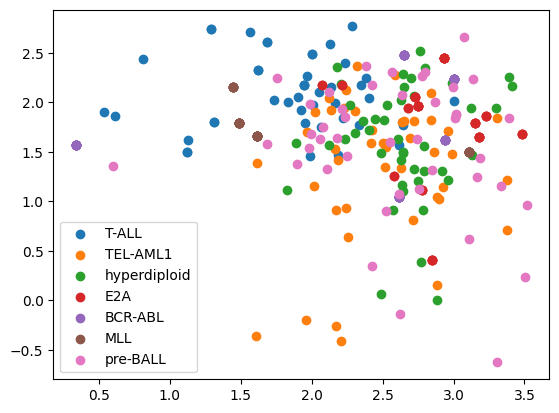

Klasyfikacja BTU...
F1 Score (BTU): 0.574
Counter({'astrocytoma': 81, 'glioblastoma': 81, 'oligodendroglioma': 81, 'non-tumor': 81})


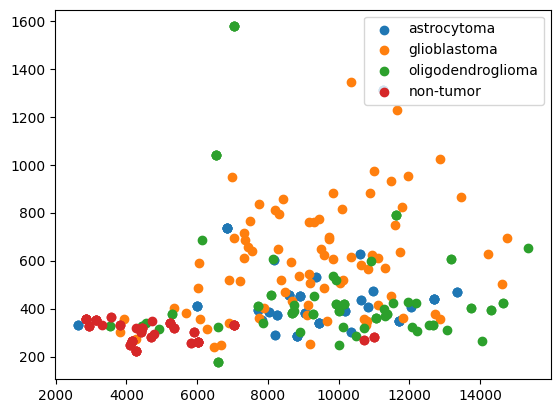

Klasyfikacja HEC...
F1 Score (HEC): 0.825
Counter({'HCC': 47, 'cirrhosisHCC': 47, 'cirrhosis': 47, 'Normal': 47})


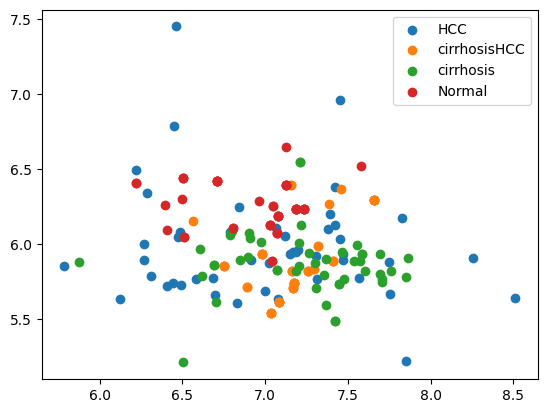

Klasyfikacja HFF...
F1 Score (HFF): 0.563
Counter({'ischemic_cardiomyopathy': 108, 'idiopathic_cardiomyopathy': 108, 'normal': 108})


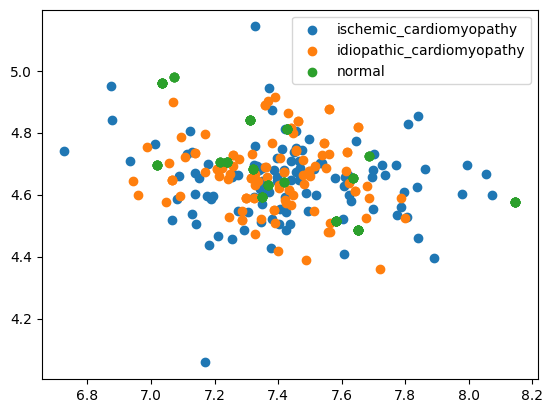

Klasyfikacja SPS...
F1 Score (SPS): 0.752
Counter({'normal': 64, 'uninvolved': 64, 'involved': 64})


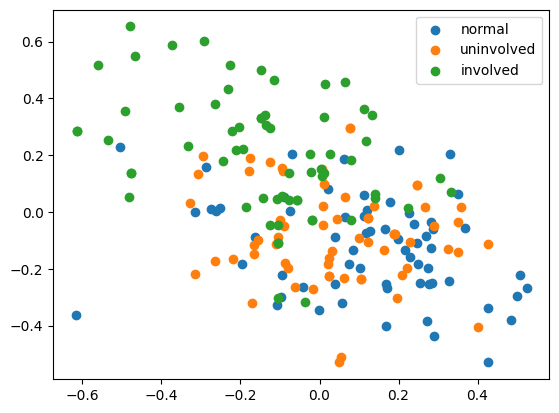

Klasyfikacja SSH...
F1 Score (SSH): 0.405
Counter({'Controls': 106, 'SIRS': 106, 'SIRS_resolved': 106, 'Sepsis': 106, 'Septic_Shock': 106})


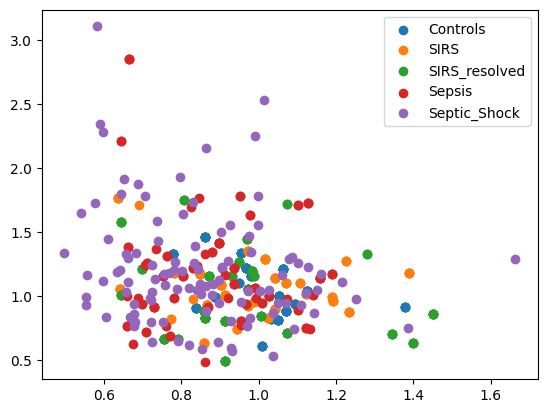

In [33]:
for name, data in datasets.items():
    print(f"Klasyfikacja {name}...")
    X = data.drop(columns=[CLASS, SAMPLE_ID]).values
    y = data[CLASS].values

    steps = [('over', RandomOverSampler(random_state=RNG)), ('model', DecisionTreeClassifier(random_state=RNG))]
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RNG)
    scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    score = mean(scores)
    print(f'F1 Score ({name}): %.3f' % score)
    
    X_res, y_res = pipeline.named_steps['over'].fit_resample(X, y)
    
    counter = Counter(y_res)
    print(counter)
    
    for label, _ in counter.items():
        row_ix = where(y_res == label)[0]
        pyplot.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()

Klasyfikacja (Undersampling)

Klasyfikacja ALL...
F1 Score (ALL): 0.319
Counter({'BCR-ABL': 4, 'E2A': 4, 'MLL': 4, 'T-ALL': 4, 'TEL-AML1': 4, 'hyperdiploid': 4, 'pre-BALL': 4})


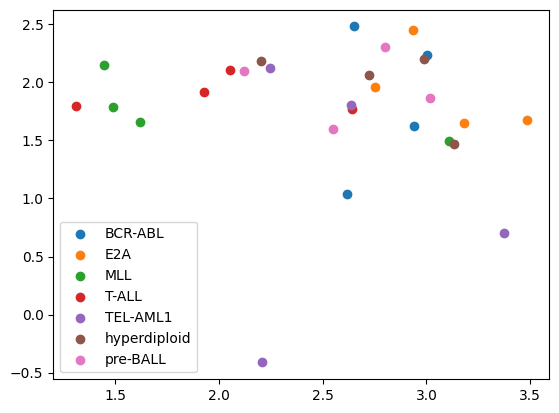

Klasyfikacja BTU...
F1 Score (BTU): 0.531
Counter({'astrocytoma': 23, 'glioblastoma': 23, 'non-tumor': 23, 'oligodendroglioma': 23})


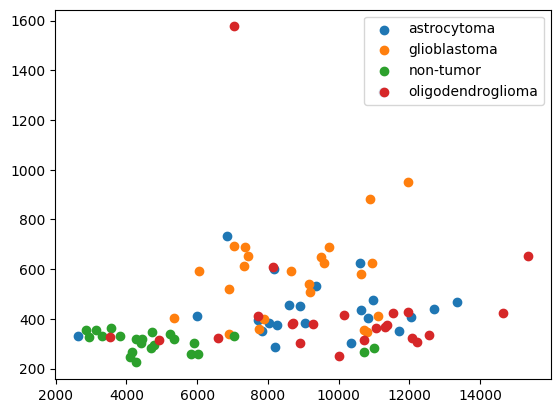

Klasyfikacja HEC...
F1 Score (HEC): 0.691
Counter({'HCC': 17, 'Normal': 17, 'cirrhosis': 17, 'cirrhosisHCC': 17})


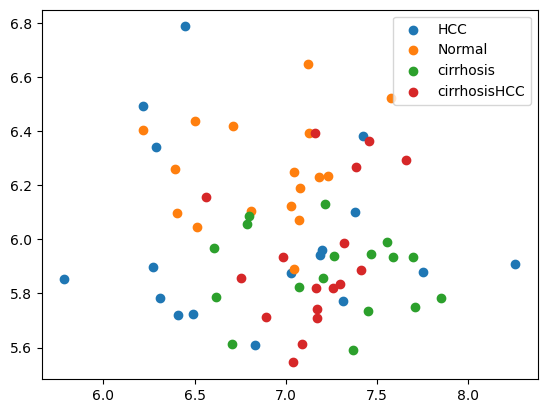

Klasyfikacja HFF...
F1 Score (HFF): 0.440
Counter({'idiopathic_cardiomyopathy': 16, 'ischemic_cardiomyopathy': 16, 'normal': 16})


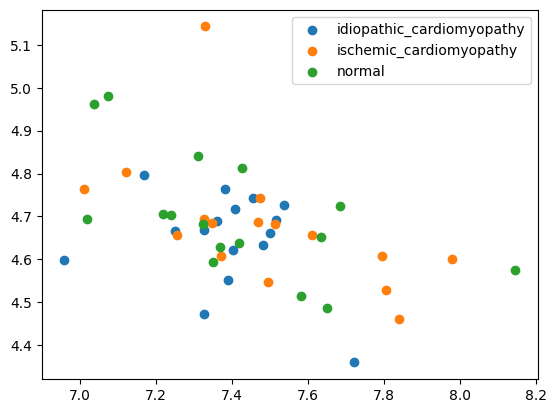

Klasyfikacja SPS...
F1 Score (SPS): 0.704
Counter({'involved': 58, 'normal': 58, 'uninvolved': 58})


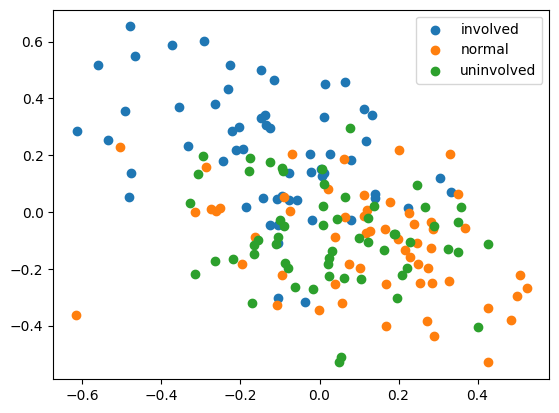

Klasyfikacja SSH...
F1 Score (SSH): 0.351
Counter({'Controls': 18, 'SIRS': 18, 'SIRS_resolved': 18, 'Sepsis': 18, 'Septic_Shock': 18})


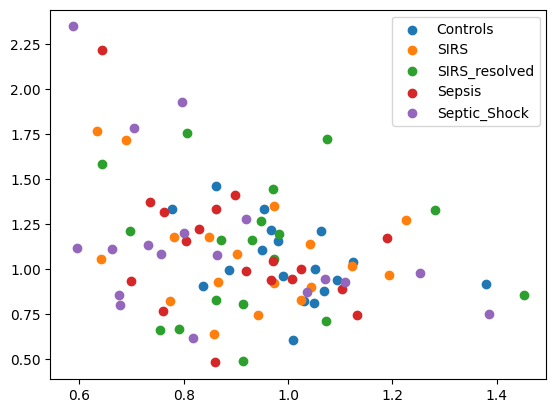

In [32]:
for name, data in datasets.items():
    print(f"Klasyfikacja {name}...")
    X = data.drop(columns=[CLASS, SAMPLE_ID]).values
    y = data[CLASS].values

    steps = [('under', RandomUnderSampler(random_state=RNG)), ('model', DecisionTreeClassifier(random_state=RNG))]
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RNG)
    scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    score = mean(scores)
    print(f'F1 Score ({name}): %.3f' % score)
    
    X_res, y_res = pipeline.named_steps['under'].fit_resample(X, y)
    
    counter = Counter(y_res)
    print(counter)
    
    for label, _ in counter.items():
        row_ix = where(y_res == label)[0]
        pyplot.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()

Klasyfikacja (Over+Undersampling SMOTE)

Klasyfikacja ALL...
F1 Score (ALL): 0.797
Counter({'BCR-ABL': 44, 'E2A': 44, 'MLL': 44, 'T-ALL': 44, 'TEL-AML1': 44, 'hyperdiploid': 44, 'pre-BALL': 44})


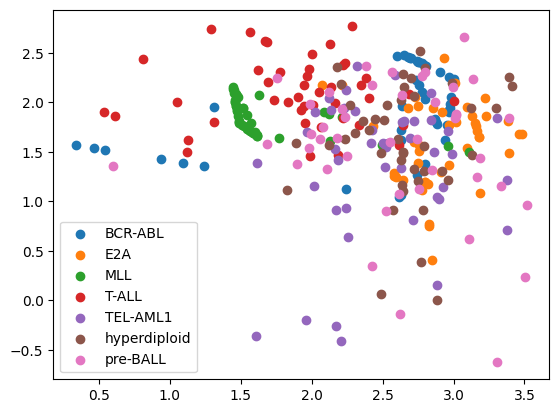

Klasyfikacja BTU...
F1 Score (BTU): 0.622
Counter({'astrocytoma': 81, 'glioblastoma': 81, 'non-tumor': 81, 'oligodendroglioma': 81})


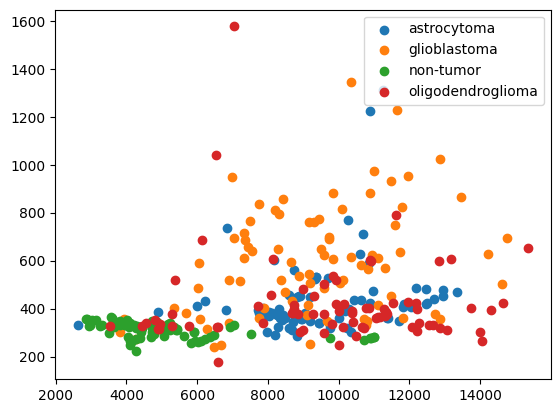

Klasyfikacja HEC...
F1 Score (HEC): 0.809
Counter({'HCC': 47, 'Normal': 47, 'cirrhosis': 47, 'cirrhosisHCC': 47})


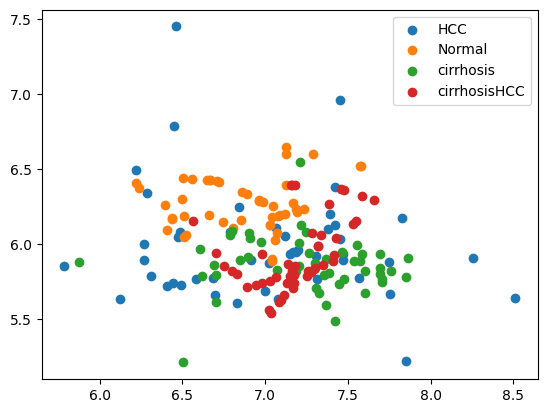

Klasyfikacja HFF...
F1 Score (HFF): 0.573
Counter({'idiopathic_cardiomyopathy': 108, 'ischemic_cardiomyopathy': 108, 'normal': 108})


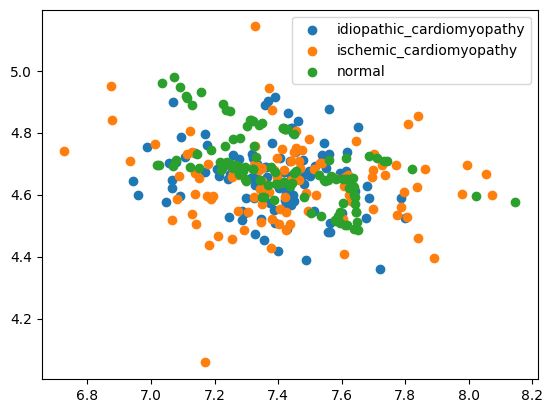

Klasyfikacja SPS...
F1 Score (SPS): 0.733
Counter({'involved': 64, 'normal': 64, 'uninvolved': 64})


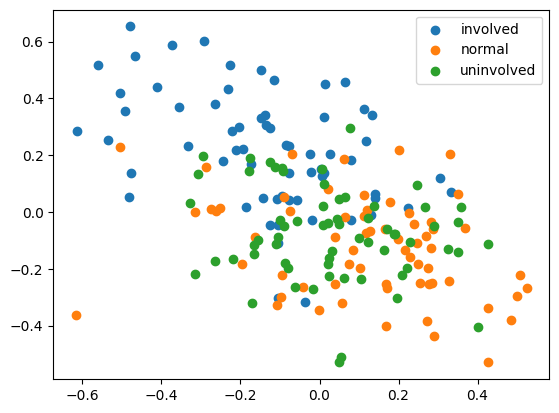

Klasyfikacja SSH...
F1 Score (SSH): 0.405
Counter({'Controls': 106, 'SIRS': 106, 'SIRS_resolved': 106, 'Sepsis': 106, 'Septic_Shock': 106})


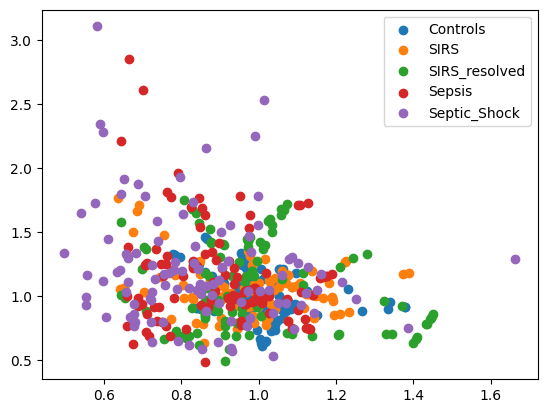

In [ ]:
for name, data in datasets.items():
    print(f"Klasyfikacja {name}...")
    X = data.drop(columns=[CLASS, SAMPLE_ID]).values
    y = data[CLASS].values
    
    steps = [('over', SMOTE(k_neighbors=2, random_state=RNG)), ('under', RandomUnderSampler(random_state=RNG)), ('model', DecisionTreeClassifier(random_state=RNG))]
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=RNG)
    scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
    score = mean(scores)
    print(f'F1 Score ({name}): %.3f' % score)
    
    steps.pop()
    pipeline = Pipeline(steps=steps)
    X_res, y_res = pipeline.fit_resample(X, y)
    
    counter = Counter(y_res)
    print(counter)
    
    for label, _ in counter.items():
        row_ix = where(y_res == label)[0]
        pyplot.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()